### DBSCAN

&nbsp;

DBSCAN is a really cool unsupervised learning. In contrast to Gaussian Mixture, it has the capability of detecting non-linear boundaries. It does not require an assumption of the number of the clusters. Instead, it requires the minimum number of samples to construct a cluster and a parameter ε to determine the radius of the cluster. A cluster is formed when sufficient data points are within the preset radius or reachable from the data points within the radius.

For technical details of DBSCAN, you can check the original paper.

https://aaai.org/Papers/KDD/1996/KDD96-037.pdf

&nbsp;

In [1]:
import sklearn.neighbors
import sklearn.cluster
import sklearn.decomposition
import sklearn.datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#create dataframe
xcol=['x0','x1','x2','x3']
ycol='y'
iris=sklearn.datasets.load_iris()
df=pd.DataFrame(iris.data,columns=xcol)

In [3]:
#each input factor has to be float/int
#sklearn has already done that for us
#but if you are using the dataset inside the repository
#you can use np.unique to convert categorical data to int
df[ycol]=iris.target

In [4]:
#minpts denotes the minimum requirement to form a cluster
#minpts should be larger than 2
#there are different empirical rules
#it can be 2 times dimensions
#or it can be dimensions+1
minpts=1+len(xcol)

In [5]:
#epsilon denotes the maximum distance of points inside the same cluster
#later we will discuss how to find optimal eps via knn
#right now we just assume its 0.6
eps=0.6

In [6]:
#we compute euclidean distance from all other data points
#we check if there are minpts neighbors suffice the distance condition
#the distance condition is that euclidean distance is smaller than eps
def check_neighbors(data,datapoint,minpts,eps):
    
    #compute euclidean distance
    distance=data[xcol]-datapoint
    distance['euclidean distance']=[sum([j**2 for j in distance.loc[i]])**0.5 for i in range(len(distance))]

    #reset index to locate the neighbors
    distance.reset_index(inplace=True)
    
    #we use minpts+1 becuz we include the core point itself
    #if there are enough neighbors
    #output the indices of neighbors
    if len(distance[distance['euclidean distance']<=eps])>=minpts+1:
        return distance[distance['euclidean distance']<=eps].index.tolist()
    else:
        return []    

In [7]:
#core part of the algorithm
def density_based(data,xcol,eps,minpts):
    
    checked=[]
    cluster=-1
    data['predict']=np.nan
    
    for i in data.index.tolist():
        
        #if the selected point is unchecked
        #we check if it has enough neighbors to become a core point
        if i not in checked:
            datapoint=data[xcol].loc[i]
            neighbors=check_neighbors(data,datapoint,minpts,eps)
            checked.append(i)            
            
            #if it is confirmed to be the core point
            #we remove itself from the neighbors
            #we increment the cluster index
            #and assign the cluster label to the core point
            if neighbors:
                neighbors.remove(i)
                cluster+=1
                data.at[i,'predict']=cluster
            else:
                continue
                
        else:
            continue
        
        #we check if the neighbors can be become core points
        #the process is pretty similar to the above
        #this part can be written in recursion
        #check the link below for more details
        # https://github.com/je-suis-tm/recursion-and-dynamic-programming
        while neighbors:
            j=neighbors.pop()
            data.at[j,'predict']=cluster
            if j not in checked:
                datapoint=data[xcol].loc[j]
                newneighbors=check_neighbors(data,datapoint,minpts,eps)
                checked.append(j)                
                neighbors+=newneighbors
    
    #we set noise at -1
    data['predict']=data['predict'].fillna(-1)
    
    return data

In [8]:
#for unsupervised learning, clf.score doesnt return the accuracy
#there is no cross validation, no known labels
#the only way to detect the accuracy is vote of the majority
#for each label given
#we check which iris type is the majority
#we consider the majority as the correct classification
#all we need to do is to count the minority
def get_accuracy(data,class_,checked):
    
    df=data.copy()
    
    #use dictionary to keep track of everything
    d={}
    
    #counting
    for i in df['predict'][df['y']==class_].unique():
        if i not in checked and i!=-1:
            d[i]=df['predict'][df['y']==class_].tolist().count(i)

    #comparison
    temp=-1
    lbl=None
    for i in d:
        if d[i]>temp:
            lbl=i
            temp=d[i]

    return len(df['predict'][df['y']==class_][df['predict']!=lbl])

In [9]:
#aggregate all functions into one big main function
def spatial_clustering(df,xcol,eps,minpts):
    
    #machine learning
    data=density_based(df,xcol,eps,minpts)
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in data['y'].unique():
        erreur+=get_accuracy(data,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(df)
    print('accuracy: %s'%(accuracy))

In [10]:
#dbscan implemented by sklearn
def skl_dbscan(df,xcol,eps,minpts):
    
    #machine learning
    clf=sklearn.cluster.DBSCAN(eps=eps,min_samples=minpts)
    clf.fit(df[xcol])    
    df['predict']=clf.fit_predict(df[xcol])
    
    #compute accuracy
    erreur=0
    checked=[]
    for i in df['y'].unique():
        erreur+=get_accuracy(df,i,checked)
        checked.append(i)
    accuracy=1-erreur/len(df)
    print('accuracy: %s'%(accuracy))

In [11]:
spatial_clustering(df,xcol,eps,minpts)

accuracy: 0.6333333333333333


In [12]:
skl_dbscan(df,xcol,eps,minpts)

accuracy: 0.6333333333333333


In [13]:
#for the purpose of visualization
#we reduce 4 dimensions to 2
#you can check more about pca in the link below
# https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
dims=2
x=sklearn.decomposition.PCA(n_components=dims).fit_transform(df[xcol])
data=density_based(df,xcol,eps,minpts)
data['dim1']=x[:,0]
data['dim2']=x[:,1]

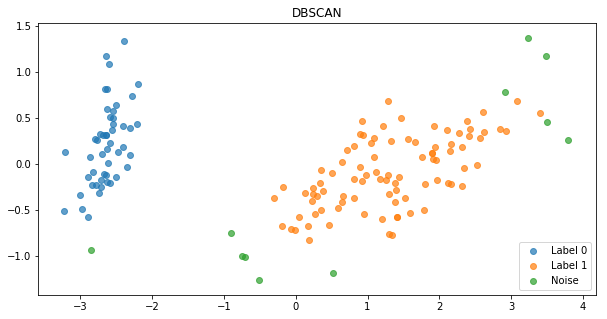

In [14]:
#viz
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)

for i in set(data['predict']):
    if i!=-1:
        plt.scatter(data['dim1'][data['predict']==i],
                    data['dim2'][data['predict']==i],
                    label=f'Label {int(i)}',alpha=0.7)
    else:
        plt.scatter(data['dim1'][data['predict']==i],
                    data['dim2'][data['predict']==i],
                    label='Noise',alpha=0.7)

plt.title('DBSCAN')
plt.legend(loc=0)
plt.show()

&nbsp;

### Selection of ε

&nbsp;

The selection of ε requires delicate balancing. If ε is too large, we will have larger but fewer clusters, vice versa. The optimal ε can be selected via Knee Method. It is quite similar to elbow method.

* Use K Nearest Neighbor with K=minpts-1
* Compute and plot KNN distance
* Find the point where the greatest surge occurs
* The underlying KNN distance is the optimal ε

Alternatively, we can use a modified version of DBSCAN, called OPTICS. OPTICS only requires minpts and it does not require ε. To determine the number of the clusters, OPTICS requires a new parameter called ξ to determine steep upward and downward areas in a reachability plot.

The details of KNN can be found in the link below.

https://github.com/je-suis-tm/machine-learning/blob/master/k%20nearest%20neighbors.ipynb

The details of Elbow Method can be found in the link below.

https://github.com/je-suis-tm/machine-learning/blob/master/k%20means.ipynb

The details of OPTICS can be found in the link below.

https://github.com/je-suis-tm/machine-learning/blob/master/optics.ipynb

&nbsp;

In [15]:
#create dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    #preset the figure
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    
    #plot left hand side
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15
    plt.legend(loc=3)
    
    #the crucial part of the function
    #both curves share x axis
    ax2=ax.twinx()
    
    #plot right hand side
    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15    
    plt.legend(loc=4)
    
    #enfin
    fig.tight_layout()
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [16]:
#estimate parameters of linear equation
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

In [17]:
#compute perpendicular distance
def get_distance(x,y,a,b):
    
    numerator=y-x*a-b
    denominator=(a**2+1)**0.5
    
    return np.abs(numerator/denominator)

In [18]:
#knee method for knn to find the optimal epsilon
def find_optimal_eps(distances):
    
    #compute perpendicular distance
    a,b=get_line_params(0,distances[0],len(distances)-1,distances[-1])

    distance=[]
    for i in range(len(distances)):    
        distance.append(get_distance(i,distances[i],a,b))
    
    #viz
    dual_axis_plot(np.arange(1,len(distance)+1),distances,distance,
                   x_label='Points Sampled by Distance',
                   y_label1='NN Distance',
                   y_label2='Perpendicular Distance',
                   legend1='NN',legend2='Knee',
                   title='Knee Method for KNN',
                   fst_color='#0abda0',sec_color='#720017')
    
    #get optimal eps
    optimal=distances[distance.index(max(distance))]
    
    return optimal   

In [19]:
#using k distance graph to get the optimal eps
def get_eps(data,xcol,minpts):
    
    #use knn to compute k distance
    clf=sklearn.neighbors.NearestNeighbors(n_neighbors=minpts-1)
    clf.fit(data[xcol])
    
    #prepare for visualization
    distances,_=clf.kneighbors(data[xcol])
    distances=sorted(distances.tolist(),key=lambda x:x[1])
    distances=[i[1] for i in distances]
    
    #viz and get eps
    optimal=find_optimal_eps(distances)
    
    return optimal

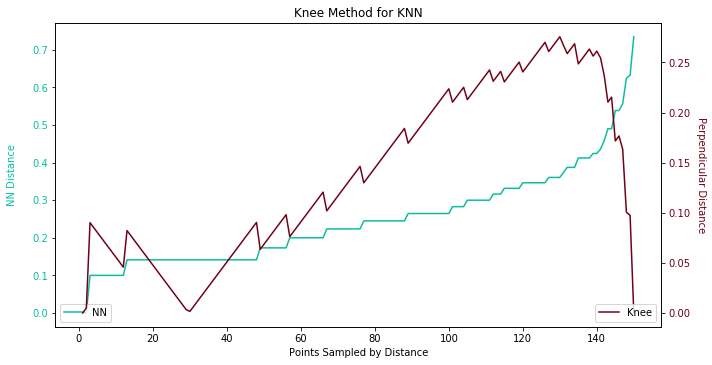

In [20]:
eps=get_eps(df,xcol,minpts)

In [21]:
#unfortunately this seems to be a terrible choice of eps
#domain knowledge is absolutely more important
eps

0.3605551275463992

In [22]:
spatial_clustering(df,xcol,eps,minpts)

accuracy: 0.4666666666666667


In [23]:
skl_dbscan(df,xcol,eps,minpts)

accuracy: 0.48
